In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keplergl import KeplerGl
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

from sspipe import p, px
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
%load_ext lab_black

# Load Data

In [359]:
%%writefile models/preprocess.py

import glob
import subprocess
import pendulum
from dataclasses import dataclass
from zipfile import ZipFile
from os.path import exists, curdir, join, abspath, splitext, basename, dirname
from typing import List

RUN_TIMESTAMP = pendulum.today().format("YYYY-MM-DD")
APP_DIRECTORY = curdir | p(abspath) | p(join, "data")


@dataclass
class Kaggle:
    name: str
    dataset: str
    source_filename: str
    destination_dir: str

    def cli_download_command(self) -> List[str]:
        return [
            "kaggle",
            "datasets",
            "download",
            "-d",
            self.dataset,
            "--file",
            self.source_filename,
            "--path",
            self.destination_dir,
            "--unzip",
        ]

    def get_path(self):
        return join(self.destination_dir, self.source_filename.split("/")[-1])


def download_data():
    directory = join(APP_DIRECTORY, RUN_TIMESTAMP)

    if not exists(directory):
        os.makedirs(directory)

    datasets = [
        Kaggle(
            name="Corona",
            dataset="imdevskp/corona-virus-report",
            source_filename="covid_19_clean_complete.csv",
            destination_dir=directory,
        ),
        Kaggle(
            name="Worldbank",
            dataset="theworldbank/world-development-indicators",
            source_filename="wdi-csv-zip-57-mb-/WDIData.csv",
            destination_dir=directory,
        ),
    ]

    # Worldbank downloads a zip file...
    unzip_files(directory)

    for kaggle_source in datasets:
        subprocess.run(kaggle_source.cli_download_command())

    return {d.name: d.get_path() for d in datasets}


def unzip_files(source_dir):
    files = glob.glob(join(source_dir, "*.zip"))
    for f in files:
        filepath = os.path.splitext(f)[0]  # unzipped path

        if not exists(filepath):
            file = filepath | p(basename)
            path = filepath | p(dirname)

            ZipFile(f).extract(member=file, path=path)


def format_columns(df):
    return (
        df.pipe(lambda df: df.rename(columns={c: c.split("/")[0] for c in df.columns}))
        .pipe(
            lambda df: df.rename(
                columns={c: c.split(" ") | p("_".join) for c in df.columns}
            )
        )
        .pipe(lambda df: df.rename(columns={c: c.upper() for c in df.columns}))
    )


Overwriting models/preprocess.py


# Preprocess Data

In [411]:
# %%writefile -a models/preprocess.py


def reshape_worldbank(df):
    indicators = (
        "Air transport, passengers carried",
        "Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)",
        "Cause of death, by non-communicable diseases (% of total)",
        "Current health expenditure per capita, PPP (current international $)",
        "Death rate, crude (per 1,000 people)",
        "Diabetes prevalence (% of population ages 20 to 79)",
        "GDP per capita, PPP (current international $)",
        "Hospital beds (per 1,000 people)",
        "Incidence of tuberculosis (per 100,000 people)",
        "International migrant stock, total",
        "International tourism, number of arrivals",
        "International tourism, number of departures",
        "Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)",
        "Life expectancy at birth, total (years)",
        "Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)",
        "Mortality rate attributed to household and ambient air pollution, age-standardized (per 100,000 population)",
        "Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)",
        "Mortality rate, adult, female (per 1,000 female adults)",
        "Mortality rate, adult, male (per 1,000 male adults)",
        "Number of people spending more than 10% of household consumption or income on out-of-pocket health care expenditure",
        "Number of people spending more than 25% of household consumption or income on out-of-pocket health care expenditure",
        "Nurses and midwives (per 1,000 people)",
        "Out-of-pocket expenditure (% of current health expenditure)",
        "PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)",
        "People using at least basic sanitation services (% of population)",
        "People using safely managed sanitation services (% of population)",
        "People with basic handwashing facilities including soap and water (% of population)",
        "Physicians (per 1,000 people)",
        "Population ages 15-64 (% of total)",
        "Population ages 65 and above (% of total)",
        "Population density (people per sq. km of land area)",
        "Population in the largest city (% of urban population)",
        "Population in urban agglomerations of more than 1 million (% of total population)",
        "Population, total",
        "Poverty headcount ratio at $3.20 a day (2011 PPP) (% of population)",
        "Prevalence of HIV, total (% of population ages 15-49)",
        "Smoking prevalence, females (% of adults)",
        "Smoking prevalence, males (% of adults)",
        "Survival to age 65, female (% of cohort)",
        "Survival to age 65, male (% of cohort)",
        "Trade (% of GDP)",
        "Tuberculosis case detection rate (%, all forms)",
        "Tuberculosis treatment success rate (% of new cases)",
        "Urban population (% of total)",
    )

    df = (
        df.pipe(lambda df: df[df["INDICATOR_NAME"].isin(indicators)])
        .drop(["INDICATOR_CODE", "COUNTRY_CODE", "UNNAMED:_63"], axis=1)
        .melt(
            id_vars=["COUNTRY_NAME", "INDICATOR_NAME"],
            var_name="YEAR",
            value_name="VALUE",
        )
        .assign(YEAR=lambda df: df.YEAR.astype("datetime64[Y]"))
        .pipe(index_year)
        .replace({"United States": "US"})
    )

    return df


def index_year(df):
    df = df.assign(
        YEAR_INDEX=lambda d: (d.YEAR - d.YEAR.min()).apply(lambda s: s.days) // 365
    )
    return df

In [361]:
d = download_data()

worldbank = d.get("Worldbank") | p(pd.read_csv) | p(format_columns)
corona_data = d.get("Corona") | p(pd.read_csv, parse_dates=["Date"]) | p(format_columns)

In [414]:
processed = worldbank | p(reshape_worldbank)

In [ ]:
data = (
    processed
    .dropna(subset=['VALUE'])
    .groupby(["COUNTRY_NAME", "INDICATOR_NAME"])
    .apply(
        lambda df: df.assign(
            SLOPE=lambda x: np.polyfit(x["YEAR_INDEX"], x["VALUE"], 1)[0],
            INTERCEPT=lambda x: np.polyfit(x["YEAR_INDEX"], x["VALUE"], 1)[1],
            TREND=lambda x: x.SLOPE * x.YEAR_INDEX + x.INTERCEPT,
        )
    )
    .reset_index(drop=True)
)

import seaborn as sns

/Users/joshzastrow/GitHub/covid-19/venv/lib/python3.8/site-packages/pandas/core/common.py:343: RankWarning: Polyfit may be poorly conditioned
  return maybe_callable(obj, **kwargs)
/Users/joshzastrow/GitHub/covid-19/venv/lib/python3.8/site-packages/pandas/core/common.py:343: RankWarning: Polyfit may be poorly conditioned
  return maybe_callable(obj, **kwargs)
/Users/joshzastrow/GitHub/covid-19/venv/lib/python3.8/site-packages/pandas/core/common.py:343: RankWarning: Polyfit may be poorly conditioned
  return maybe_callable(obj, **kwargs)
/Users/joshzastrow/GitHub/covid-19/venv/lib/python3.8/site-packages/pandas/core/common.py:343: RankWarning: Polyfit may be poorly conditioned
  return maybe_callable(obj, **kwargs)
/Users/joshzastrow/GitHub/covid-19/venv/lib/python3.8/site-packages/pandas/core/common.py:343: RankWarning: Polyfit may be poorly conditioned
  return maybe_callable(obj, **kwargs)
/Users/joshzastrow/GitHub/covid-19/venv/lib/python3.8/site-packages/pandas/core/common.py:343: 

In [439]:
data[data.COUNTRY_NAME == "US"]

,COUNTRY_NAME,INDICATOR_NAME,YEAR,VALUE,YEAR_INDEX,SLOPE,INTERCEPT,TREND
641212,US,"Air transport, passengers carried",1960-01-01,NaN,0,NaN,NaN,NaN
641213,US,"Air transport, passengers carried",1961-01-01,NaN,1,NaN,NaN,NaN
641214,US,"Air transport, passengers carried",1962-01-01,NaN,2,NaN,NaN,NaN
641215,US,"Air transport, passengers carried",1963-01-01,NaN,3,NaN,NaN,NaN
641216,US,"Air transport, passengers carried",1964-01-01,NaN,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
643803,US,Urban population (% of total),2014-01-01,81.483,54,NaN,NaN,NaN
643804,US,Urban population (% of total),2015-01-01,81.671,55,NaN,NaN,NaN
643805,US,Urban population (% of total),2016-01-01,81.862,56,NaN,NaN,NaN
643806,US,Urban population (% of total),2017-01-01,82.058,57,NaN,NaN,NaN


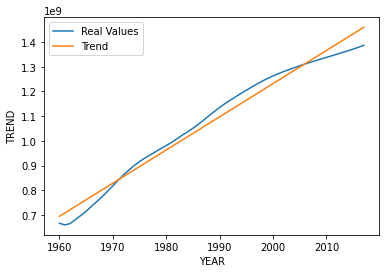

In [429]:
d = data[(data.INDICATOR_NAME == "Population, total") & (data.COUNTRY_NAME == "China")]

ax = sns.lineplot("YEAR", "VALUE", data=d, label="Real Values")
sns.lineplot("YEAR", "TREND", data=d, ax=ax, label="Trend")

In [ ]:
(
    df
    .pipe(lambda df: df[(df['Indicator Name'] == 'Tuberculosis treatment success rate (% of new cases)')])
    .pipe(lambda df: df[df.value.notnull()])
#     .pipe(lambda df: df[df['Country Name'] == 'Afghanistan'])
    .groupby('Country Name').apply(lambda df: df.sort_values('Year', ascending=True).tail(1)).reset_index(drop=True)
)

In [ ]:
fig, ax = plt.subplots(plots, 1, figsize=(20, 10 * plots))

for i, group in enumerate(df.groupby('Indicator Name')):
    name, data = group
    
    sns.lineplot("Year", "value", data=data, ax=ax[i])
    ax[i].set_title(name)

In [ ]:
global_history

# Enrich and Format Data

In [ ]:
def preprocess(global_history):
    return (
        global_history
        .pipe(lambda df: df.assign(DateIndex=(df.Date - df.Date.min()).apply(lambda d: d.days)))
        .pipe(lambda df: df.Confirmed >= 100)
        .sort_values(["DateIndex", "Confirmed"], ascending=True)
        
        .assign(region=lambda df: df["Province"].mask(pd.isnull, df['Country']))
        .dropna()
        .reset_index(drop=True)
    )
df = global_history.pipe(preprocess)

In [ ]:
df

In [ ]:
infections_scaler = {
    m: MinMaxScaler() for m in global_history["Country/Region"].unique()
}
fatalities_scaler = {
    m: MinMaxScaler() for m in global_history["Country/Region"].unique()
}

final_data = global_history.assign(
    ConfirmedCases_normalized=(
        global_history.groupby("Country/Region").ConfirmedCases.transform(
            lambda d: infections_scaler[d.name]
            .fit_transform(d.values.reshape(-1, 1))
            .reshape(-1,)
        )
    ),
    Fatalities_normalized=(
        global_history.groupby("Country/Region").Fatalities.transform(
            lambda d: fatalities_scaler[d.name]
            .fit_transform(d.values.reshape(-1, 1))
            .reshape(-1,)
        )
    ),
)

fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(
    "DateIndex", "ConfirmedCases_normalized", data=final_data, ax=ax,
)

ax.set_xlabel("Date Since Patient Zero")

In [ ]:
final_data.head()

In [ ]:
final_data.groupby("DateIndex").ConfirmedCases.mean().plot()

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
# (cali_history.plot("DateIndex", "ConfirmedCases", ax=ax, label="Confirmed Cases"))

# (
#     cali_history.plot(
#         "DateIndex", "Fatalities", ax=ax, label="California", secondary_y=True
#     )
# )
# (
#     global_history.groupby("Country/Region").apply(
#         lambda group: group.plot(
#             "DateIndex",
#             "ConfirmedCases",
#             ax=ax,
#             label=group.name + "Cases",
#             secondary_y=True,
#         )
#     )
# )

(
    global_history.groupby("Country/Region").apply(
        lambda group: group.plot(
            "DateIndex",
            "Fatalities",
            ax=ax,
            label=group.name + "Fatalities",
            secondary_y=True,
        )
    )
)

In [ ]:
global_history.DateIndex

In [ ]:
unique_cols = cali_history.pipe(lambda df: [df[c].nunique() > 1 for c in df.columns])
cali_history.iloc[:, unique_cols]